# Introduction

This is a submission made for IEEE cs club application's AI task.

The highlight of this submission is that I don't use any libraries like tensorflow or pytorch's autograd engine. Instead the neural network trained is using Nanograd, that's the autograd engine that I have built. Alongside that, I also use custom implementation of the optimizer SGD that's built for nanograd, and custom implementation of ce_loss function and relu!

With this we get the accuracy score of ~0.898 on validation set.


Though nanograd currently depends on pytorch, that's only because we leverage their tensors as computational backends i.e. to perform fast matrix multiplications and other matrix operations.


## Getting started


```bash
$ git clone https://github.com/IAmPara0x/nanograd
$ cd nanograd
```

* The notebook of interest is present in `./examples/fashion_mnist.ipynb`.
* Start that notebook using jupyter lab
* and then modify the `DATA_DIR` variable to point to the dataset folder.


### NOTES regarding dependencies

* The only out of the ordinary dependency that we use is idx2numpy
* other than that every other dependency required is pretty standard like pytorch, numpy, pandas, matplotlib, seaborn, etc.

In [1]:
import idx2numpy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd

In [2]:
DATA_DIR = "./data/dataset_aiml_task"

In [3]:
images = idx2numpy.convert_from_file(f"{DATA_DIR}/images-idx3-ubyte")
labels = idx2numpy.convert_from_file(f"{DATA_DIR}/labels-idx1-ubyte")

In [4]:

def plot_fashion_images(images, labels, class_names, num_images=8):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

## Define some constants

In [5]:
IMG_HEIGHT = 28
IMG_WIDTH  = 28
SEED = 42

CLASS_NAMES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

CLASS_NAME_2_LABEL = {n: idx for idx, n in enumerate(CLASS_NAMES)}

In [6]:

# SEED for reproducibility
np.random.seed(SEED)

# EDA

* Let's Look at some images from the dataset

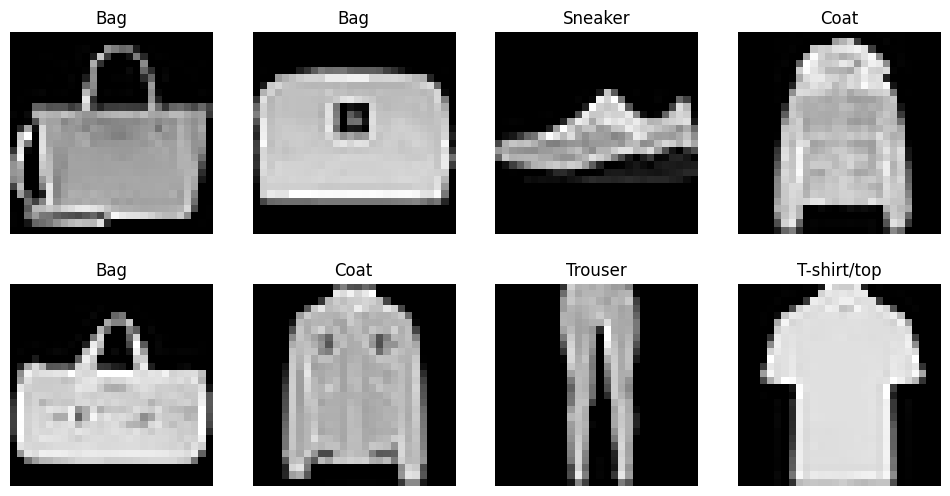

In [7]:
num_images = 8

sampled_idxs = np.random.choice(images.shape[0], num_images, replace=False)


plot_fashion_images(images[sampled_idxs], labels[sampled_idxs], CLASS_NAMES)


* Let's look at the labels available for each class in the dataset

/tmp/ipykernel_44599/1356036100.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=CLASS_NAMES, y=counts, palette="rocket")


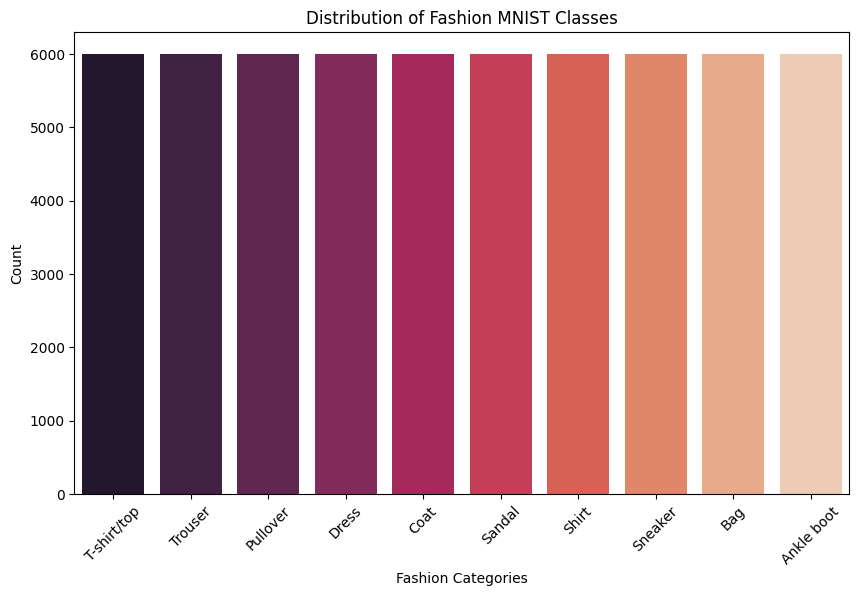

In [8]:


unique, counts = np.unique(labels, return_counts=True)


plt.figure(figsize=(10, 6))
sns.barplot(x=CLASS_NAMES, y=counts, palette="rocket")


plt.xlabel("Fashion Categories")
plt.ylabel("Count")
plt.title("Distribution of Fashion MNIST Classes")
plt.xticks(rotation=45)
plt.show()

* We can see that all the labels are equally present in the dataset

* Let's plot mean pixel intensities of each class sample and check their probability distribution

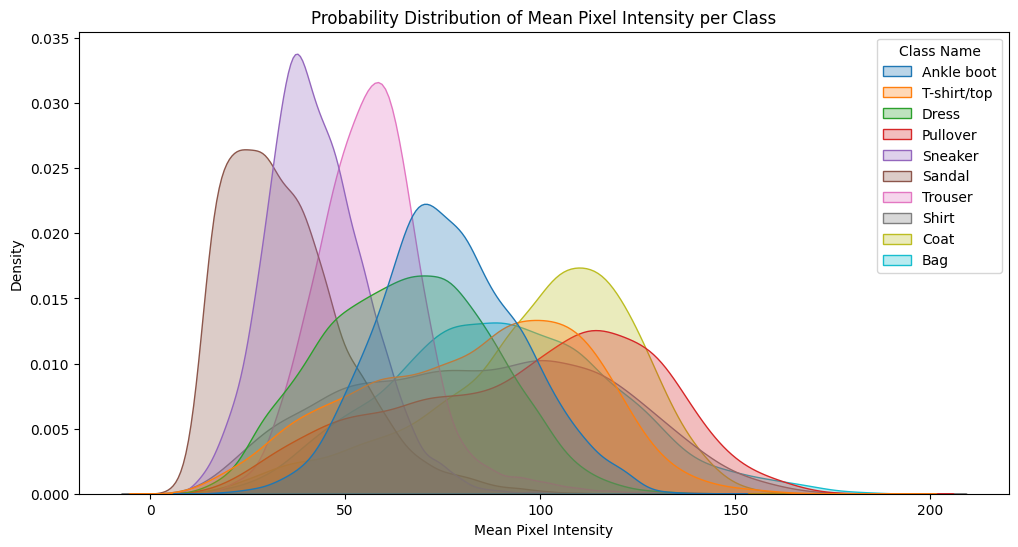

In [9]:


mean_intensities = images.mean(axis=(1, 2))


df = pd.DataFrame({"Mean Intensity": mean_intensities, "Label": labels})
df["Class Name"] = df["Label"].apply(lambda x: CLASS_NAMES[x])

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x="Mean Intensity", hue="Class Name", fill=True, common_norm=False, alpha=0.3)
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Density")
plt.title("Probability Distribution of Mean Pixel Intensity per Class")

plt.show()


* It seems like sandal has lowest mean pixel intensity.
* Pullover seems to have the highest mean pixel intensity.

The implies that Sandal may generally have less foreground pixels and Pullover have more foreground pixels.

Let's see if it's true

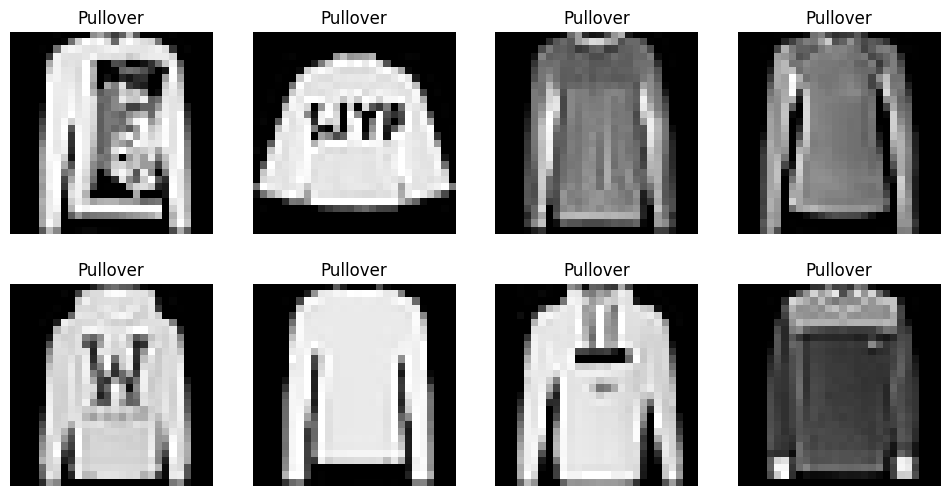

In [10]:

num_images = 8

sampled_idxs = np.random.choice(6000, num_images, replace=False)

plot_fashion_images((images[labels==CLASS_NAME_2_LABEL["Pullover"]])[sampled_idxs], (labels[labels==2])[sampled_idxs], CLASS_NAMES)

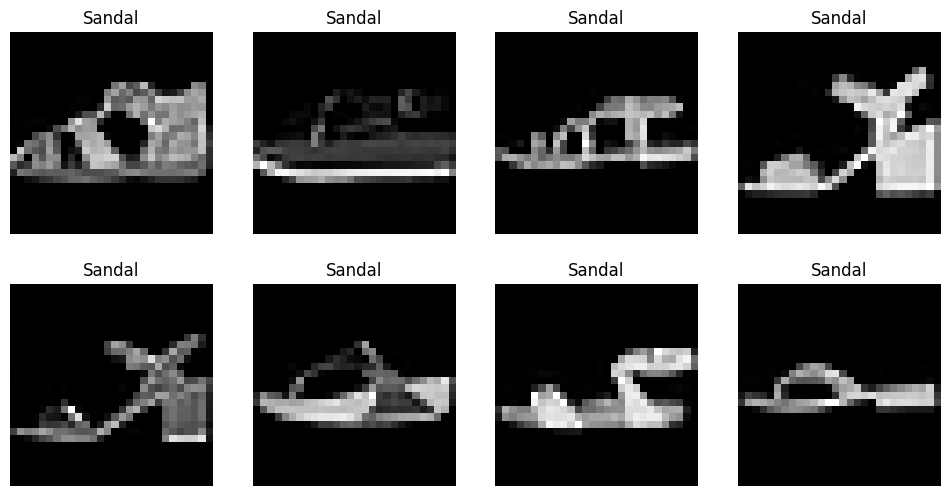

In [11]:


num_images = 8

sampled_idxs = np.random.choice(6000, num_images, replace=False)

plot_fashion_images((images[labels==CLASS_NAME_2_LABEL["Sandal"]])[sampled_idxs], (labels[labels==5])[sampled_idxs], CLASS_NAMES)

* Our inference was indeed correct that sandals have very less forground pixels and their intensities are not high compared to pullover which almost cover the whole image

# Logistic Regression based classification

In [12]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [13]:


X_train,X_test, y_train, y_test  = train_test_split(np.array(images) / 255.0,labels,test_size=0.2,random_state=SEED, shuffle=True)


X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# NOTE: Actually what's happening here is if we take native res of the image i.e. 784 dimension it's taking a lot of time for LogisticRegression to converge
#       Hence we use dimensionality reduction technique, and reduce the number of dimensions using PCA, take all the dimensions that accounts for 95% of the variance in the images which is roughly 255 dims
pca = PCA(n_components=0.95, random_state=SEED)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


X_train_pca, y_train = shuffle(X_train_pca, y_train, random_state=SEED)

# Again for speed we only fit on 20K images
X_train_pca = X_train_pca[:20000]
y_train = y_train[:20000]


model = LogisticRegression(
    max_iter=500,
    solver='saga',
    multi_class='multinomial',
    tol=1e-3,
    n_jobs=-1,
    C=0.1
)
model.fit(X_train_pca, y_train)


y_pred = model.predict(X_test_pca)




/home/paradox/Desktop/ai/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Visualize Logistic Regression Accuracy Report

Test Accuracy: 0.8443

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1202
           1       0.98      0.97      0.97      1219
           2       0.75      0.74      0.74      1205
           3       0.84      0.87      0.86      1184
           4       0.73      0.77      0.75      1202
           5       0.93      0.92      0.93      1211
           6       0.63      0.57      0.60      1218
           7       0.91      0.91      0.91      1159
           8       0.95      0.93      0.94      1197
           9       0.93      0.95      0.94      1203

    accuracy                           0.84     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.84      0.84      0.84     12000



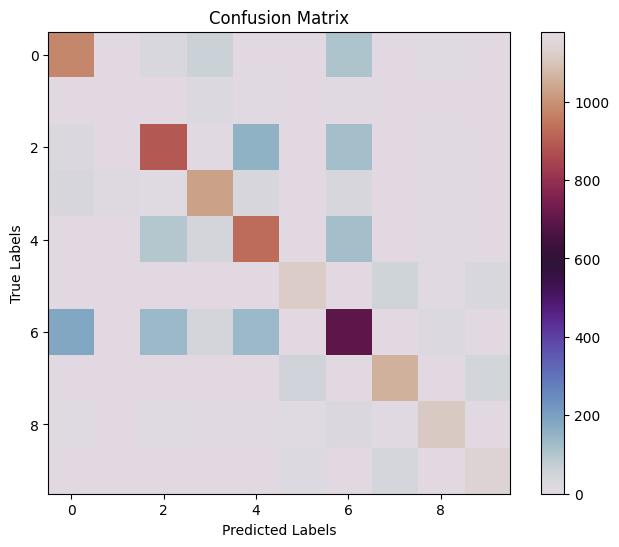

In [18]:

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# We collect the classification report stuff like: f1, recall, precision, etc.
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap="twilight")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Training NN using Nanograd

In [19]:
import sys

sys.path.append("..")

In [20]:
from nanograd.autograd import Tensor
from nanograd.optim import SGD
from nanograd.utils import crossentropy_loss, softmax, uniform


from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch

* Training Hyperparameters

In [36]:
DEVICE = "cpu"
EPOCHS = 48
BATCH_SIZE=128
HEIGHT=28
WIDTH=28
N_CLASSES = 10
TEST = False
TEST_SPLIT = 0.2


In [42]:
def init_model():

    N = HEIGHT * WIDTH
    scale = lambda f_in: (3 / f_in) ** 0.5

    w1 = Tensor(uniform(lower=-scale(N), upper=scale(N), shape=(N,N*2)), _test=TEST)
    b1 = Tensor(torch.zeros(N*2), _test=TEST)

    w2 = Tensor(uniform(lower=-scale(N), upper=scale(N), shape=(N*2,N*2)), _test=TEST)
    b2 = Tensor(torch.zeros(N*2), _test=TEST)

    w3 = Tensor(uniform(lower=-scale(N_CLASSES), upper=scale(N_CLASSES), shape=(N*2,N_CLASSES)), _test=TEST)
    b3 = Tensor(torch.zeros(N_CLASSES), _test=TEST)

    def model(x,y):

        h1 = (x.matmul(w1) + b1).relu()
        h2 = (h1.matmul(w2) + b2).relu()
        logits = h2.matmul(w3) + b3
        probs = softmax(logits, 1)
        loss = crossentropy_loss(y, probs, N_CLASSES)
        return (loss, probs)

    return model, dict(w1=w1,b1=b1,w2=w2,b2=b2,w3=w3,b3=b3)


In [43]:
model,params = init_model()
optimizer = SGD([*params.values()], lr=1e-2)

In [24]:
images,labels = np.array(images) / 255.0,np.array(labels)
X_train,X_test, y_train, y_test  = train_test_split(images,labels,test_size=TEST_SPLIT,random_state=SEED, shuffle=True)

In [44]:


training_loss = []
validation_loss = []
accuracy = []

for epoch in range(EPOCHS):

    print("\n")
    epoch_training_loss = []
    epoch_validation_loss = []
    epoch_accuracy = []


    for batch_idx in (pbar := tqdm(range(0, len(X_train), BATCH_SIZE))):

        optimizer.zero_grad()
        x = Tensor(X_train[batch_idx: batch_idx + BATCH_SIZE].reshape(-1, IMG_HEIGHT * IMG_WIDTH).astype(np.float32), requires_grad=False, _test=TEST)
        y = y_train[batch_idx: batch_idx + BATCH_SIZE]

        (loss, _) = model(x,y.tolist())
        loss.backward()
        optimizer.step()

        epoch_training_loss.append(float(loss.value))

        pbar.set_description(f"epoch: {epoch}, average_training_loss: {np.mean(epoch_training_loss):.4f}, loss: {loss.value.item():.4f}")

    training_loss.append(sum(epoch_training_loss) / len(epoch_training_loss))

    for batch_idx in (pbar := tqdm(range(0, len(X_test), BATCH_SIZE))):

        x = Tensor(X_test[batch_idx: batch_idx + BATCH_SIZE].reshape(-1, IMG_HEIGHT * IMG_WIDTH).astype(np.float32))
        y = y_test[batch_idx: batch_idx + BATCH_SIZE]

        (loss, probs) = model(x, y.tolist())
        epoch_validation_loss.append(float(loss.value))

        preds = probs.value.argmax(dim=-1).numpy()
        acc = accuracy_score(y, preds)
        epoch_accuracy.append(acc)

        pbar.set_description(f"epoch: {epoch}, average_validation_loss: {np.mean(epoch_validation_loss):.4f}, accuracy: {np.mean(epoch_accuracy):.4f}")

    validation_loss.append(sum(epoch_validation_loss) / len(epoch_validation_loss))
    accuracy.append(np.mean(epoch_accuracy))


epoch: 0, average_training_loss: 0.7270, loss: 0.4639: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.84it/s]
epoch: 0, average_validation_loss: 0.4226, accuracy: 0.8556: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 488.05it/s]


epoch: 1, average_training_loss: 0.3892, loss: 0.3574: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 150.07it/s]
epoch: 1, average_validation_loss: 0.3799, accuracy: 0.8697: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 478.88it/s]


epoch: 2, average_training_loss: 0.3422, loss: 0.3095: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 147.31it/s]
epoch: 2, average_validation_loss: 0.3586, accuracy: 0.8754: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 463.87it/s]


epoch: 3, average_training_loss: 0.3121, loss: 0.2768: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 147.58it/s]
epoch: 3, average_validation_loss: 0.3449, accuracy: 0.8803: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 274.31it/s]


epoch: 4, average_training_loss: 0.2895, loss: 0.2578: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.15it/s]
epoch: 4, average_validation_loss: 0.3365, accuracy: 0.8827: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 481.99it/s]


epoch: 5, average_training_loss: 0.2715, loss: 0.2392: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.36it/s]
epoch: 5, average_validation_loss: 0.3298, accuracy: 0.8855: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 463.28it/s]


epoch: 6, average_training_loss: 0.2563, loss: 0.2267: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.62it/s]
epoch: 6, average_validation_loss: 0.3248, accuracy: 0.8865: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 481.53it/s]


epoch: 7, average_training_loss: 0.2432, loss: 0.2166: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.27it/s]
epoch: 7, average_validation_loss: 0.3207, accuracy: 0.8867: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 464.91it/s]


epoch: 8, average_training_loss: 0.2316, loss: 0.2060: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 146.72it/s]
epoch: 8, average_validation_loss: 0.3171, accuracy: 0.8869: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 464.89it/s]


epoch: 9, average_training_loss: 0.2216, loss: 0.1987: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 146.66it/s]
epoch: 9, average_validation_loss: 0.3144, accuracy: 0.8875: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 465.46it/s]


epoch: 10, average_training_loss: 0.2122, loss: 0.1921: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 141.42it/s]
epoch: 10, average_validation_loss: 0.3121, accuracy: 0.8880: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 487.43it/s]


epoch: 11, average_training_loss: 0.2037, loss: 0.1837: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.99it/s]
epoch: 11, average_validation_loss: 0.3100, accuracy: 0.8888: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 487.18it/s]


epoch: 12, average_training_loss: 0.1960, loss: 0.1772: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 150.00it/s]
epoch: 12, average_validation_loss: 0.3084, accuracy: 0.8890: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 485.49it/s]


epoch: 13, average_training_loss: 0.1889, loss: 0.1706: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.72it/s]
epoch: 13, average_validation_loss: 0.3067, accuracy: 0.8899: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 484.88it/s]


epoch: 14, average_training_loss: 0.1823, loss: 0.1663: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.48it/s]
epoch: 14, average_validation_loss: 0.3055, accuracy: 0.8898: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 483.38it/s]


epoch: 15, average_training_loss: 0.1761, loss: 0.1603: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.72it/s]
epoch: 15, average_validation_loss: 0.3043, accuracy: 0.8895: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 484.03it/s]


epoch: 16, average_training_loss: 0.1704, loss: 0.1566: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 148.87it/s]
epoch: 16, average_validation_loss: 0.3036, accuracy: 0.8909: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 278.16it/s]


epoch: 17, average_training_loss: 0.1649, loss: 0.1526: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.85it/s]
epoch: 17, average_validation_loss: 0.3026, accuracy: 0.8913: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 483.25it/s]


epoch: 18, average_training_loss: 0.1598, loss: 0.1479: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.09it/s]
epoch: 18, average_validation_loss: 0.3019, accuracy: 0.8912: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 484.68it/s]


epoch: 19, average_training_loss: 0.1550, loss: 0.1436: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.26it/s]
epoch: 19, average_validation_loss: 0.3013, accuracy: 0.8918: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 482.21it/s]


epoch: 20, average_training_loss: 0.1504, loss: 0.1404: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.77it/s]
epoch: 20, average_validation_loss: 0.3007, accuracy: 0.8916: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 483.32it/s]


epoch: 21, average_training_loss: 0.1461, loss: 0.1367: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.00it/s]
epoch: 21, average_validation_loss: 0.3002, accuracy: 0.8923: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 479.81it/s]


epoch: 22, average_training_loss: 0.1420, loss: 0.1339: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 148.80it/s]
epoch: 22, average_validation_loss: 0.2998, accuracy: 0.8926: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 475.81it/s]


epoch: 23, average_training_loss: 0.1381, loss: 0.1308: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 139.72it/s]
epoch: 23, average_validation_loss: 0.2993, accuracy: 0.8926: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 484.87it/s]


epoch: 24, average_training_loss: 0.1343, loss: 0.1274: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 148.37it/s]
epoch: 24, average_validation_loss: 0.2988, accuracy: 0.8927: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 479.88it/s]


epoch: 25, average_training_loss: 0.1306, loss: 0.1244: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 148.60it/s]
epoch: 25, average_validation_loss: 0.2987, accuracy: 0.8929: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 479.81it/s]


epoch: 26, average_training_loss: 0.1273, loss: 0.1225: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 148.65it/s]
epoch: 26, average_validation_loss: 0.2985, accuracy: 0.8936: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 481.39it/s]


epoch: 27, average_training_loss: 0.1240, loss: 0.1187: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 148.25it/s]
epoch: 27, average_validation_loss: 0.2984, accuracy: 0.8938: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 480.66it/s]


epoch: 28, average_training_loss: 0.1207, loss: 0.1173: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 147.23it/s]
epoch: 28, average_validation_loss: 0.2981, accuracy: 0.8940: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 476.09it/s]


epoch: 29, average_training_loss: 0.1177, loss: 0.1147: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 138.73it/s]
epoch: 29, average_validation_loss: 0.2980, accuracy: 0.8941: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 496.02it/s]


epoch: 30, average_training_loss: 0.1147, loss: 0.1120: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 148.61it/s]
epoch: 30, average_validation_loss: 0.2980, accuracy: 0.8946: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 481.67it/s]


epoch: 31, average_training_loss: 0.1119, loss: 0.1092: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 148.46it/s]
epoch: 31, average_validation_loss: 0.2976, accuracy: 0.8947: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 489.04it/s]


epoch: 32, average_training_loss: 0.1092, loss: 0.1067: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 150.01it/s]
epoch: 32, average_validation_loss: 0.2977, accuracy: 0.8953: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 491.83it/s]


epoch: 33, average_training_loss: 0.1066, loss: 0.1043: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.92it/s]
epoch: 33, average_validation_loss: 0.2980, accuracy: 0.8951: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 494.80it/s]


epoch: 34, average_training_loss: 0.1041, loss: 0.1015: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.79it/s]
epoch: 34, average_validation_loss: 0.2980, accuracy: 0.8951: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 502.09it/s]


epoch: 35, average_training_loss: 0.1016, loss: 0.1003: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.29it/s]
epoch: 35, average_validation_loss: 0.2982, accuracy: 0.8956: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 487.77it/s]


epoch: 36, average_training_loss: 0.0992, loss: 0.0985: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 142.24it/s]
epoch: 36, average_validation_loss: 0.2984, accuracy: 0.8960: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 491.82it/s]


epoch: 37, average_training_loss: 0.0970, loss: 0.0960: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.53it/s]
epoch: 37, average_validation_loss: 0.2985, accuracy: 0.8964: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 495.95it/s]


epoch: 38, average_training_loss: 0.0948, loss: 0.0949: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 150.03it/s]
epoch: 38, average_validation_loss: 0.2986, accuracy: 0.8964: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 495.42it/s]


epoch: 39, average_training_loss: 0.0927, loss: 0.0916: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 150.33it/s]
epoch: 39, average_validation_loss: 0.2987, accuracy: 0.8960: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 492.57it/s]


epoch: 40, average_training_loss: 0.0906, loss: 0.0906: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 150.08it/s]
epoch: 40, average_validation_loss: 0.2991, accuracy: 0.8961: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 484.23it/s]


epoch: 41, average_training_loss: 0.0886, loss: 0.0889: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 150.24it/s]
epoch: 41, average_validation_loss: 0.2991, accuracy: 0.8964: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 487.62it/s]


epoch: 42, average_training_loss: 0.0867, loss: 0.0873: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 142.12it/s]
epoch: 42, average_validation_loss: 0.2994, accuracy: 0.8965: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 493.25it/s]


epoch: 43, average_training_loss: 0.0848, loss: 0.0849: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 148.91it/s]
epoch: 43, average_validation_loss: 0.2997, accuracy: 0.8968: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 489.74it/s]


epoch: 44, average_training_loss: 0.0830, loss: 0.0830: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.76it/s]
epoch: 44, average_validation_loss: 0.2998, accuracy: 0.8964: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 489.08it/s]


epoch: 45, average_training_loss: 0.0812, loss: 0.0818: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.16it/s]
epoch: 45, average_validation_loss: 0.3001, accuracy: 0.8967: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 493.05it/s]


epoch: 46, average_training_loss: 0.0795, loss: 0.0790: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.58it/s]
epoch: 46, average_validation_loss: 0.3003, accuracy: 0.8970: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 490.66it/s]


epoch: 47, average_training_loss: 0.0779, loss: 0.0781: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 149.92it/s]
epoch: 47, average_validation_loss: 0.3003, accuracy: 0.8972: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 489.61it/s]


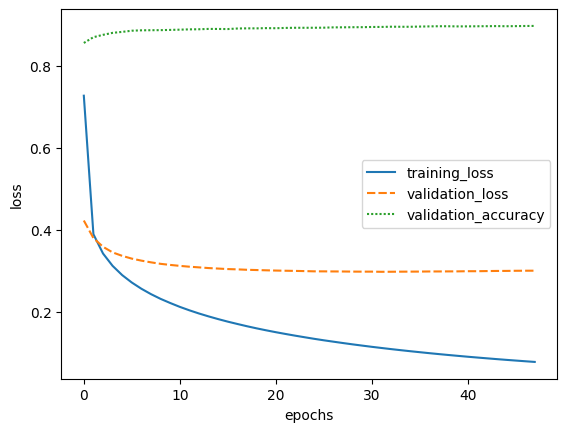

In [45]:

df = pd.DataFrame({"training_loss": training_loss, "validation_loss": validation_loss, "validation_accuracy": accuracy})
sns.lineplot(data=df)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

* Now let's check what our Neural Network has learnt

In [46]:
N = 10
x = Tensor(X_test[:N].reshape(-1, IMG_HEIGHT * IMG_WIDTH).astype(np.float32))
y = y_test[:N]

(loss, probs) = model(x, y.tolist())
preds = probs.value.argmax(dim=-1).squeeze()

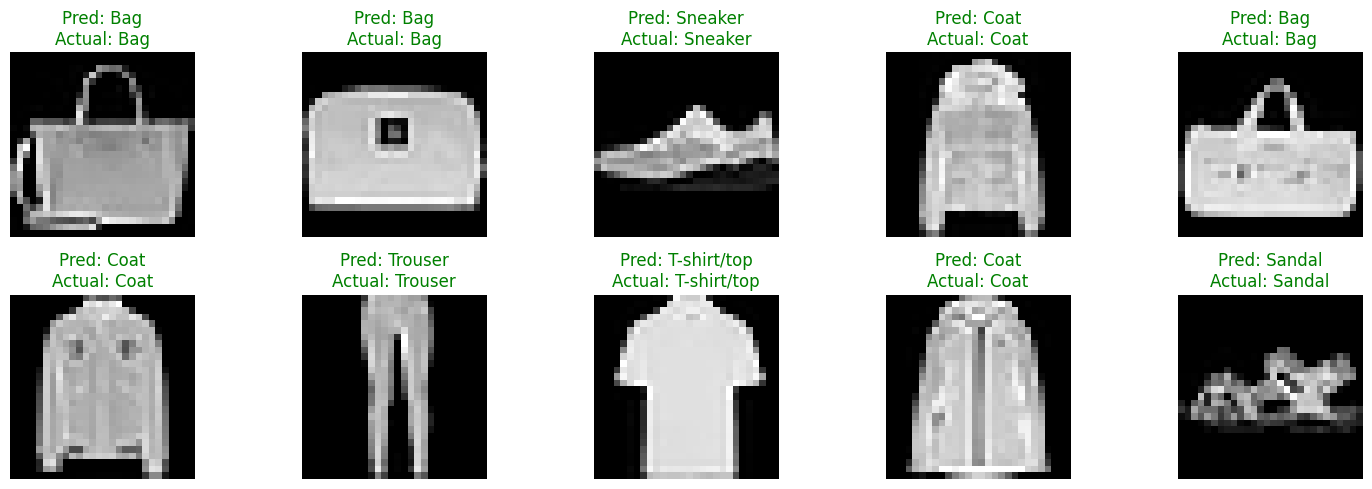

In [47]:

# Plot the images with predicted and actual labels
plt.figure(figsize=(15, 5))
for idx in range(N):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(X_test[idx], cmap="gray")
    plt.axis("off")
    title = f"Pred: {CLASS_NAMES[preds[idx]]}\nActual: {CLASS_NAMES[y[idx]]}"
    plt.title(title, color="green" if preds[idx] == y[idx] else "red")

plt.tight_layout()
plt.show()


* Wow all/most of the images has been be classified successfully !!